Naive Jaw Localisation
====

Trying a simple method for localising the fish jaw.

The skull is the largest region of high contrast in the image - we should be able to look for this.


In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath("") + "/..")

img_dir = os.path.abspath("") + "/images/"
print(img_dir)
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

/home/mh19137/fish_test/localisation/images/


In [2]:
""" Read in and display a jaw image """

import numpy as np

img_no = 56
img = np.load(f"../downsampled/{img_no:03}.npy")

In [3]:
""" Convert to 0-255 greyscale from floating point; but don't convert to int as this loses precision """

img = (img - img.min()) / (img.max() - img.min()) * 255

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '32'}>,
         <Axes: title={'center': '64'}>, <Axes: title={'center': '96'}>],
        [<Axes: title={'center': '128'}>, <Axes: title={'center': '160'}>,
         <Axes: title={'center': '192'}>, <Axes: title={'center': '224'}>],
        [<Axes: title={'center': '256'}>, <Axes: title={'center': '288'}>,
         <Axes: title={'center': '320'}>, <Axes: title={'center': '352'}>],
        [<Axes: title={'center': '384'}>, <Axes: title={'center': '416'}>,
         <Axes: title={'center': '448'}>, <Axes: title={'center': '480'}>]],
       dtype=object))

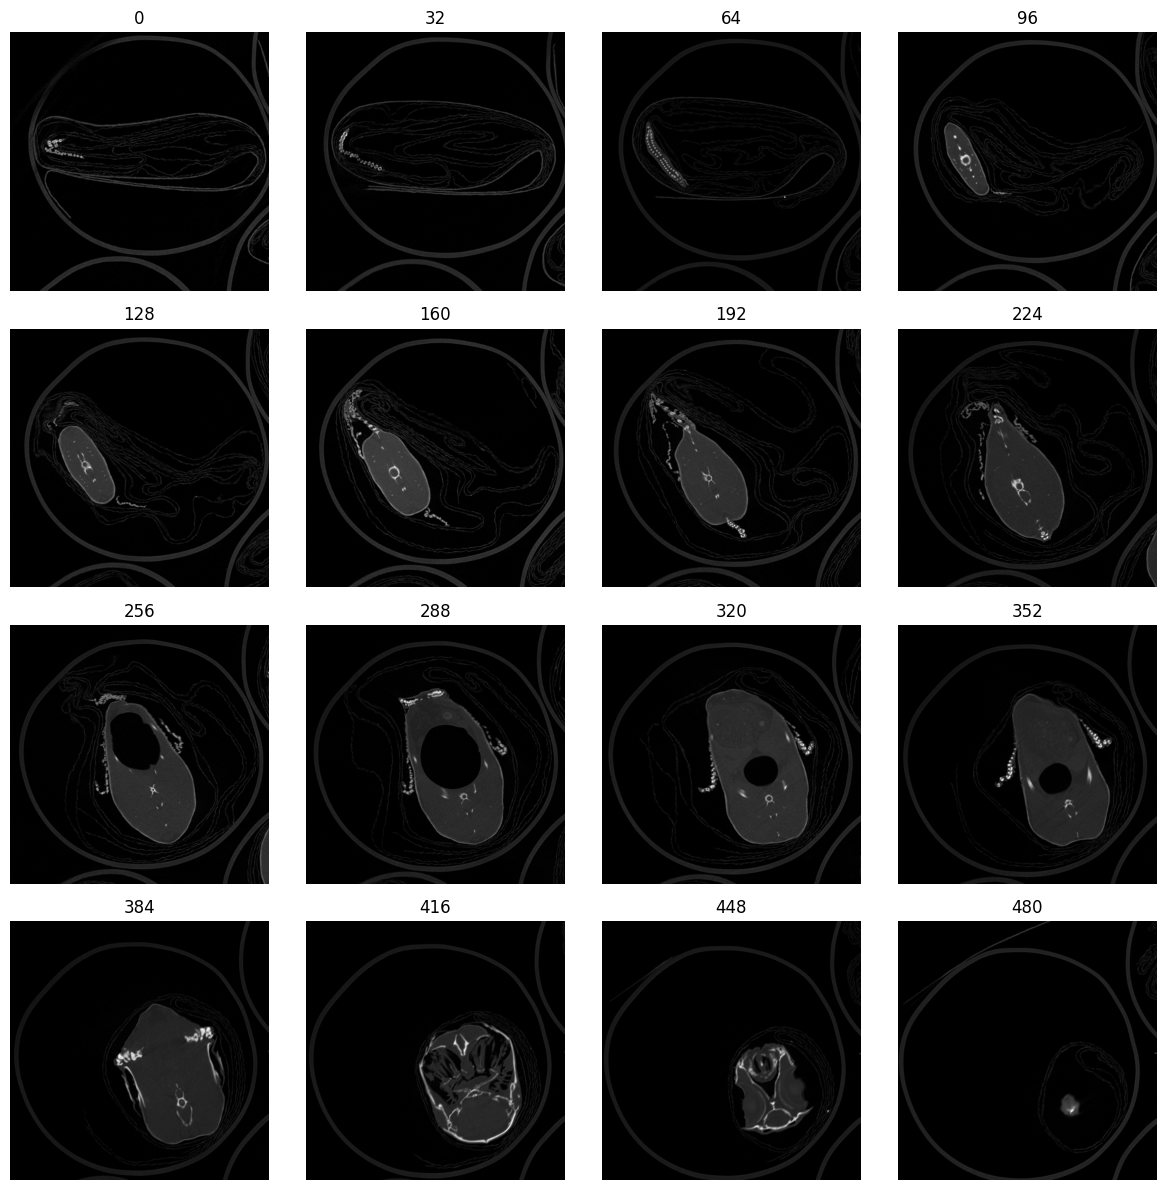

In [4]:
from dev import plot

plot.plot_arr(img)

In [5]:
""" Equalise histogram """

from skimage.exposure import rescale_intensity

saturated_pct = 0.5
v_min, v_max = np.percentile(img, (saturated_pct, 100 - saturated_pct))

equalised = rescale_intensity(img, in_range=(v_min, v_max))

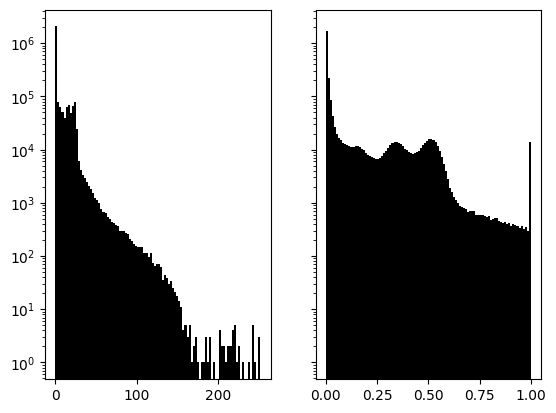

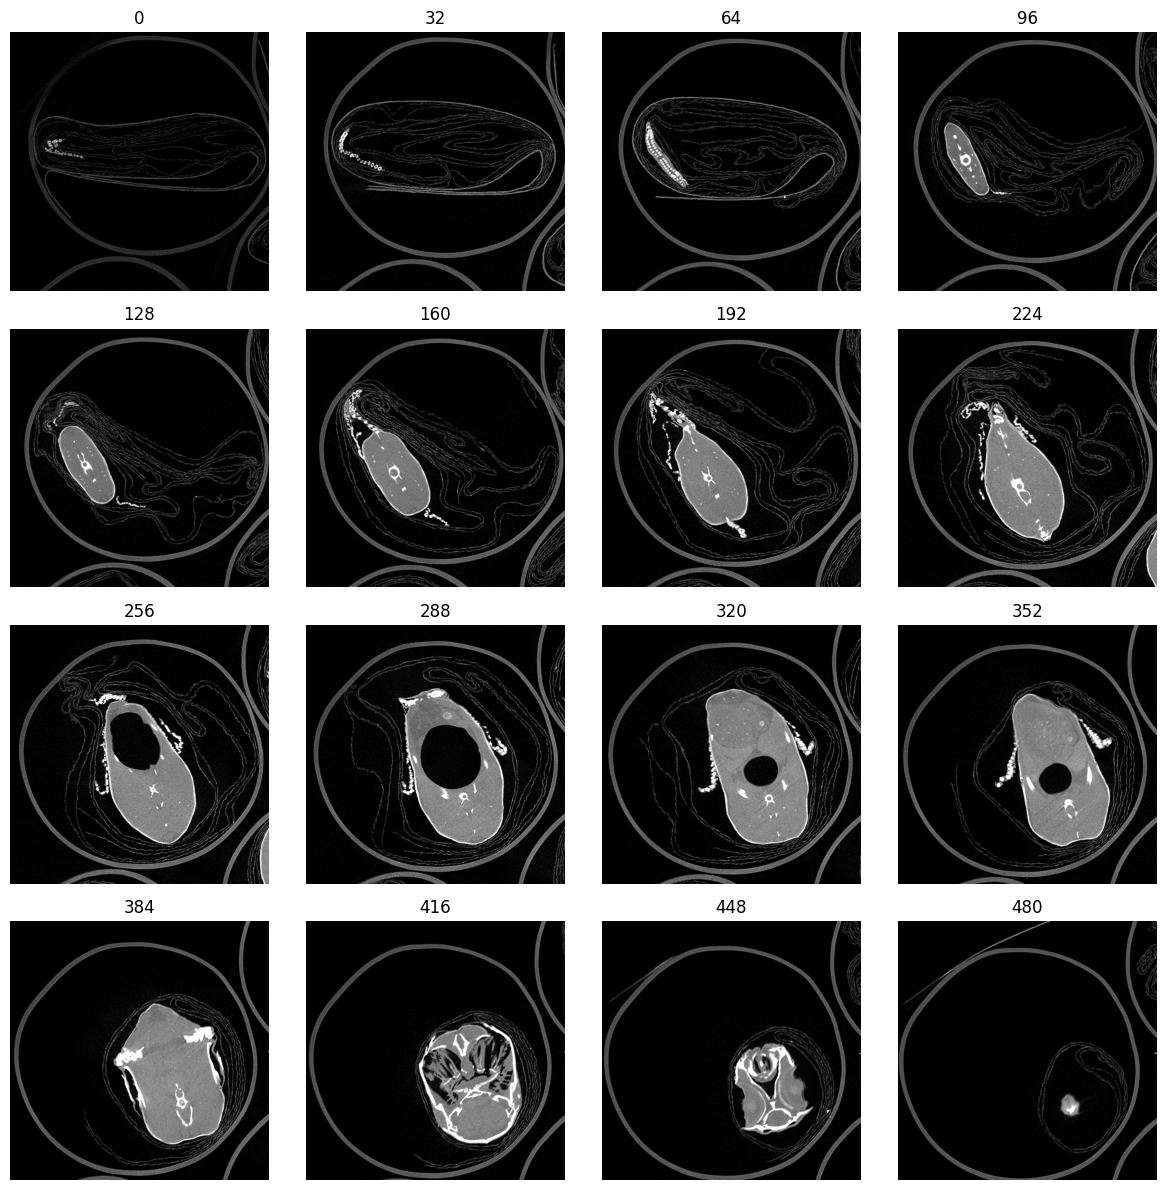

In [6]:
""" Plot a histogram of voxel intensities """

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharey=True)

axes[0].hist(img.flat[::50], bins=100, color="k")
axes[1].hist(equalised.flat[::50], bins=100, color="k")
axes[0].set_yscale("log")

fig, _ = plot.plot_arr(equalised)
fig.savefig(f"{img_dir}/equalised_{img_no:03}.png")

In [7]:
""" For various thresholds, plot the number of voxels above that threshold """

from tqdm import tqdm

print(equalised.min(), equalised.max())

thresholds = np.linspace(equalised.min(), equalised.max(), 100)

n_white = [np.sum(equalised > threshold) for threshold in tqdm(thresholds)]

0.0 1.0


100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


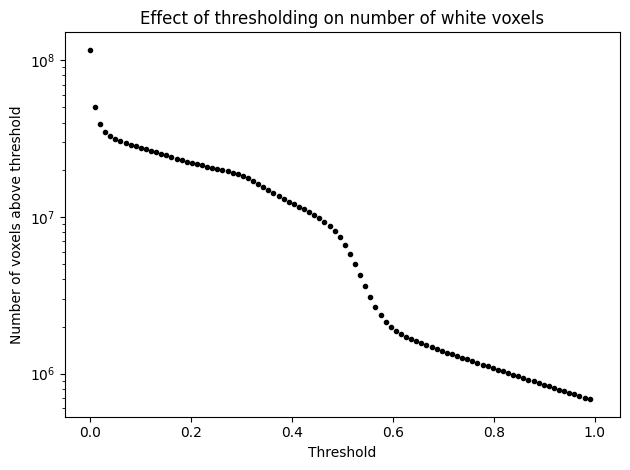

In [8]:
fig, axis = plt.subplots()
axis.plot(thresholds, n_white, "k.")


axis.set_yscale("log")
axis.set_xlabel("Threshold")
axis.set_ylabel("Number of voxels above threshold")
axis.set_title("Effect of thresholding on number of white voxels")
fig.tight_layout()

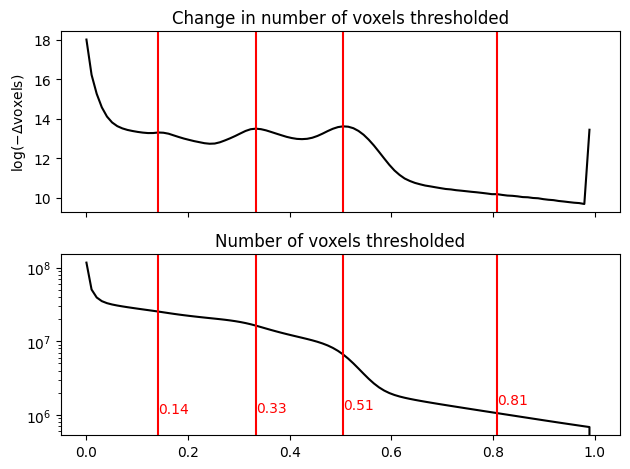

In [9]:
""" Find where the threshold changes - this means a new tissue has been thresholded out """

from scipy.signal import find_peaks

log_diff = np.log(-np.diff(n_white))

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(thresholds[:-1], log_diff, "k")
axes[1].plot(thresholds, n_white, "k")

peaks = thresholds[np.array(find_peaks(log_diff)[0])]

for i, p in enumerate(peaks):
    for axis in axes:
        axis.axvline(p, color="r")
    axis.text(p, 1e6 + 0.5 * 2**i * 1e5, f"{p:.2f}", color="r")

axes[0].set_title("Change in number of voxels thresholded")
axes[0].set_ylabel(r"$\log(-\Delta\text{voxels})$")

axes[1].set_title("Number of voxels thresholded")
axes[1].set_yscale("log")

fig.tight_layout()
fig.savefig(f"{img_dir}/thresholds_{img_no:03}.png")

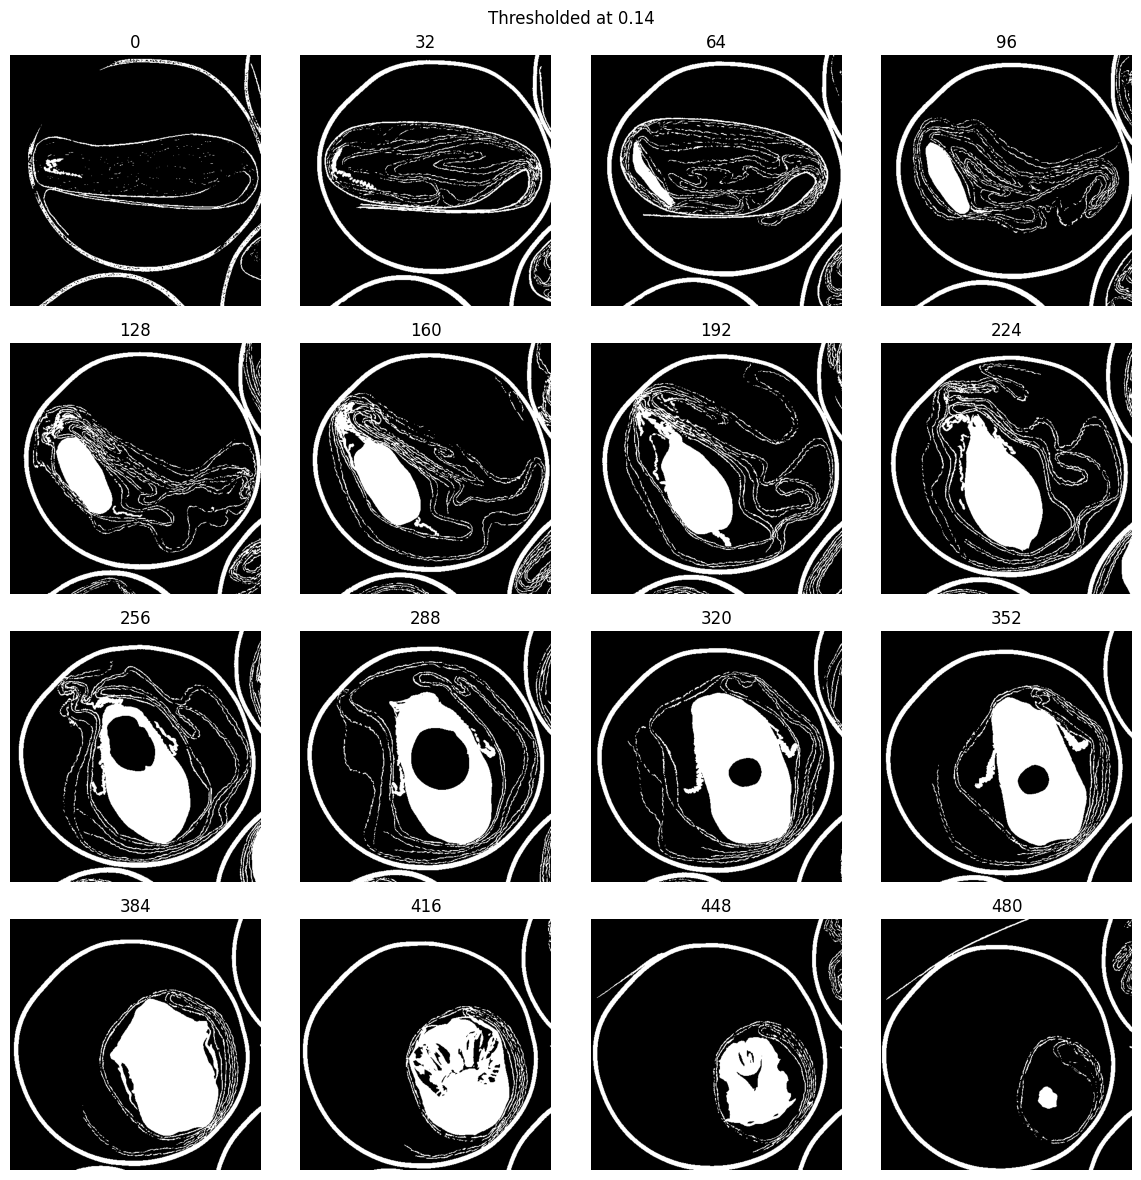

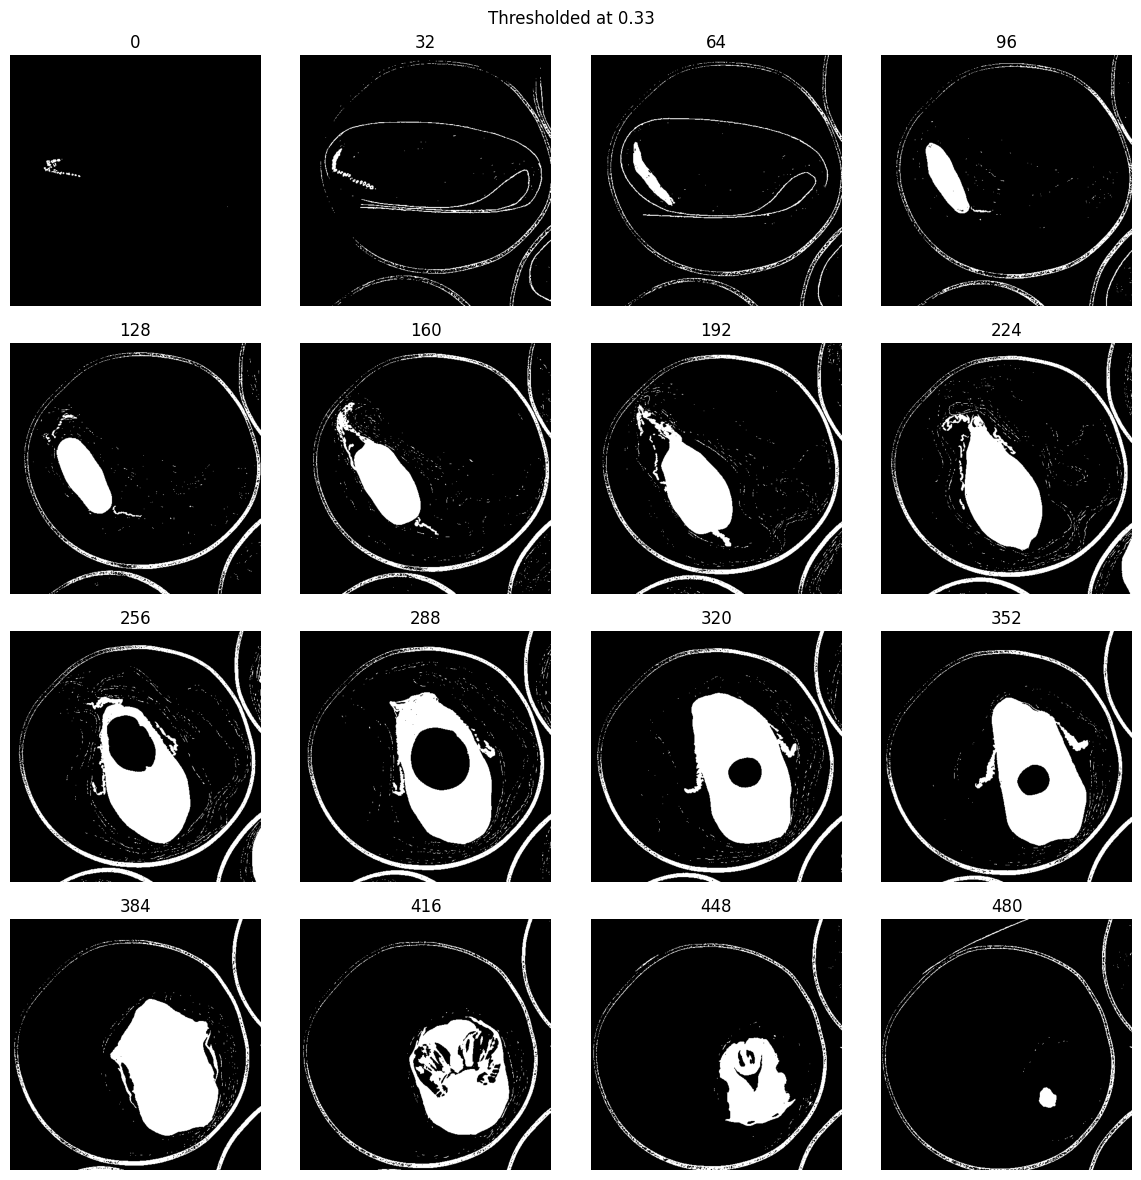

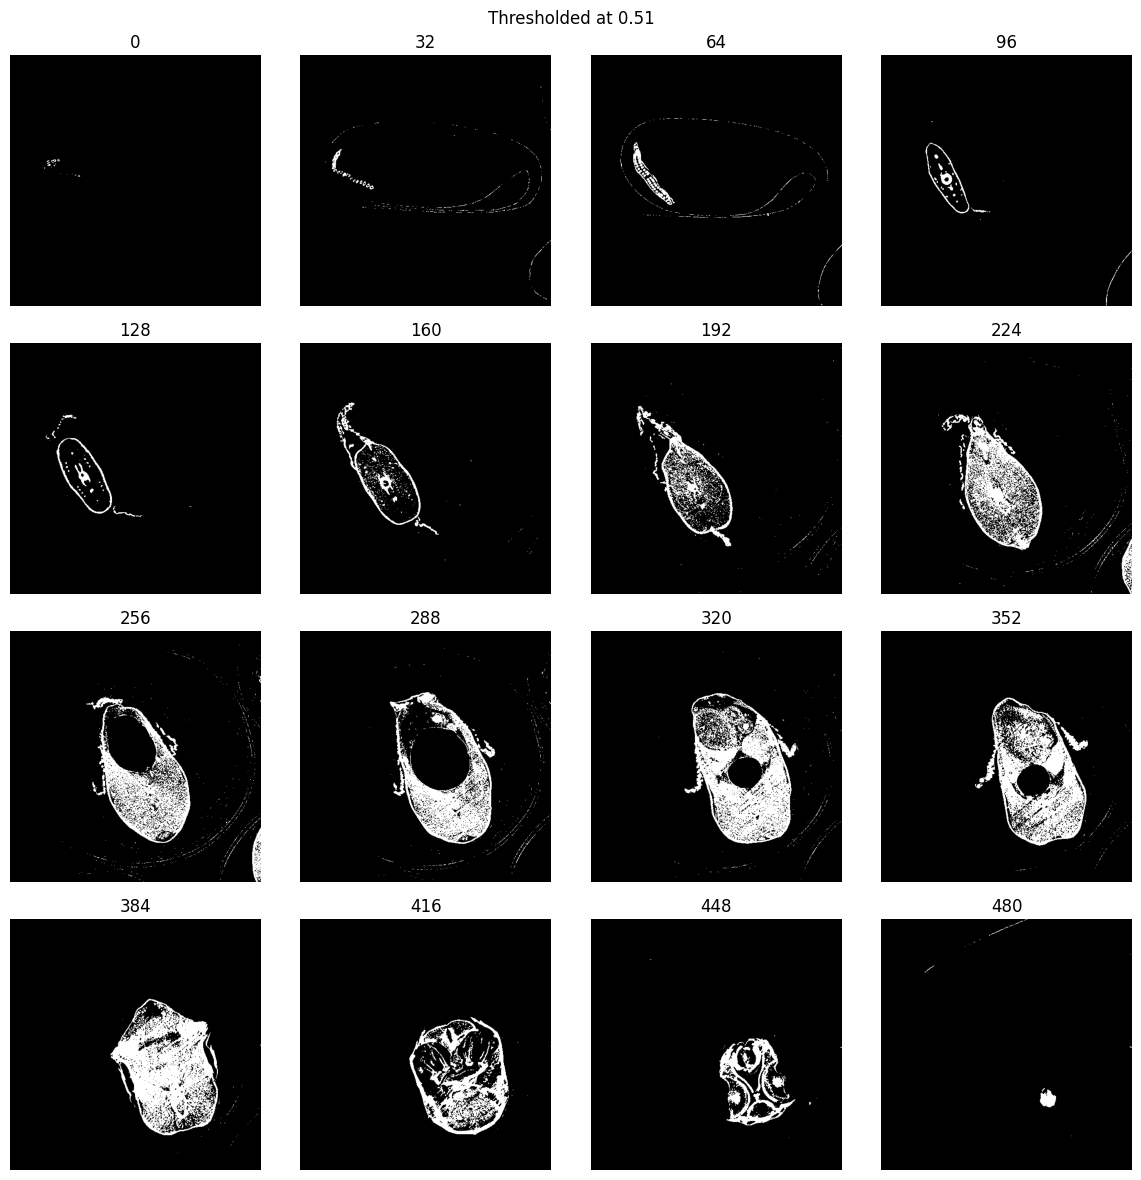

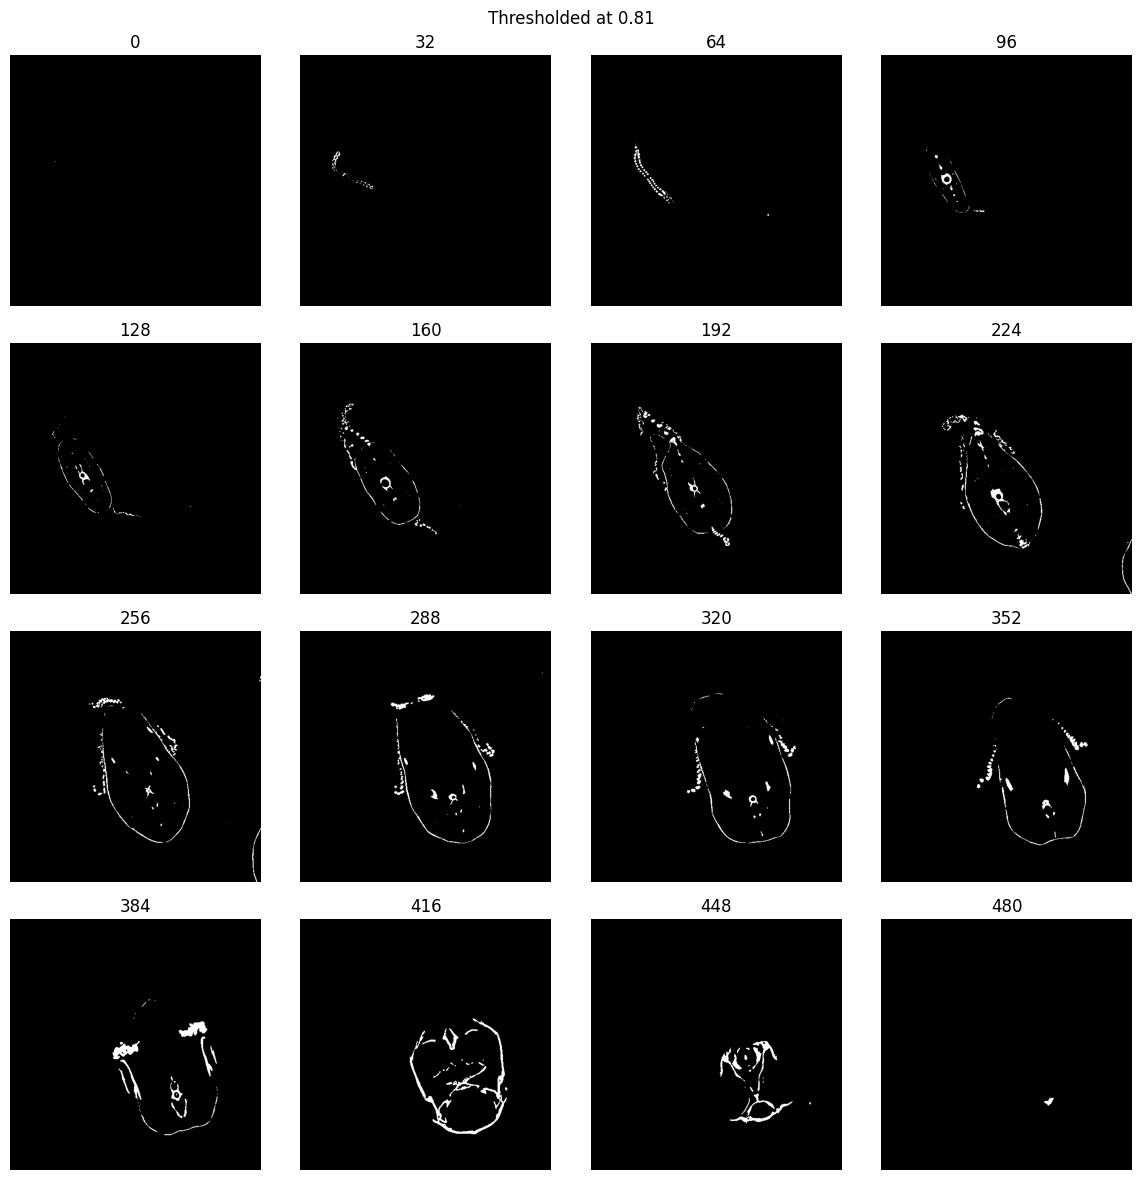

In [10]:
""" We should see a few plateaus as different tissues are segmented - plot the result of thresholding for these """

for val in peaks:
    fig, axes = plot.plot_arr(equalised > val)
    fig.suptitle(f"Thresholded at {val:.2f}")
    fig.tight_layout()
    fig.savefig(f"{img_dir}/thresholded_{img_no:03}_{val:.2f}.png")

In [46]:
thresholded = equalised > peaks[-1]

In [110]:
""" Use a spherical kernel that we'll convolve with """

from skimage.morphology import ball

ball_size = 60
struct = ball(ball_size)

In [57]:
from matplotlib.gridspec import GridSpec
from multiprocessing import Process


def plot_voxels():
    fig = plt.figure()

    gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

    ball_axis = fig.add_subplot(gs[0], projection="3d")
    fish_axis = fig.add_subplot(gs[1], projection="3d")

    _ = ball_axis.voxels(struct, alpha=0.5)
    ball_axis.set_axis_off()
    print("ball plotted")

    _ = fish_axis.voxels(thresholded)
    fish_axis.set_axis_off()

    for axis in [ball_axis, fish_axis]:
        axis.view_init(30, 30)
        axis.set_xlim(0, thresholded.shape[0])
        axis.set_ylim(0, thresholded.shape[1])
        axis.set_zlim(0, thresholded.shape[2])

    fig.savefig(f"{img_dir}/3d_{img_no:03}.png")


voxel_proc = Process(target=plot_voxels)

# This takes too long
# voxel_proc.start()  

ball plotted


In [59]:
""" Apply a Gaussian filter """

from skimage.filters import gaussian

filtered = gaussian(thresholded, sigma=ball_size / 3)

(<Figure size 1200x1200 with 16 Axes>,
 array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '32'}>,
         <Axes: title={'center': '64'}>, <Axes: title={'center': '96'}>],
        [<Axes: title={'center': '128'}>, <Axes: title={'center': '160'}>,
         <Axes: title={'center': '192'}>, <Axes: title={'center': '224'}>],
        [<Axes: title={'center': '256'}>, <Axes: title={'center': '288'}>,
         <Axes: title={'center': '320'}>, <Axes: title={'center': '352'}>],
        [<Axes: title={'center': '384'}>, <Axes: title={'center': '416'}>,
         <Axes: title={'center': '448'}>, <Axes: title={'center': '480'}>]],
       dtype=object))

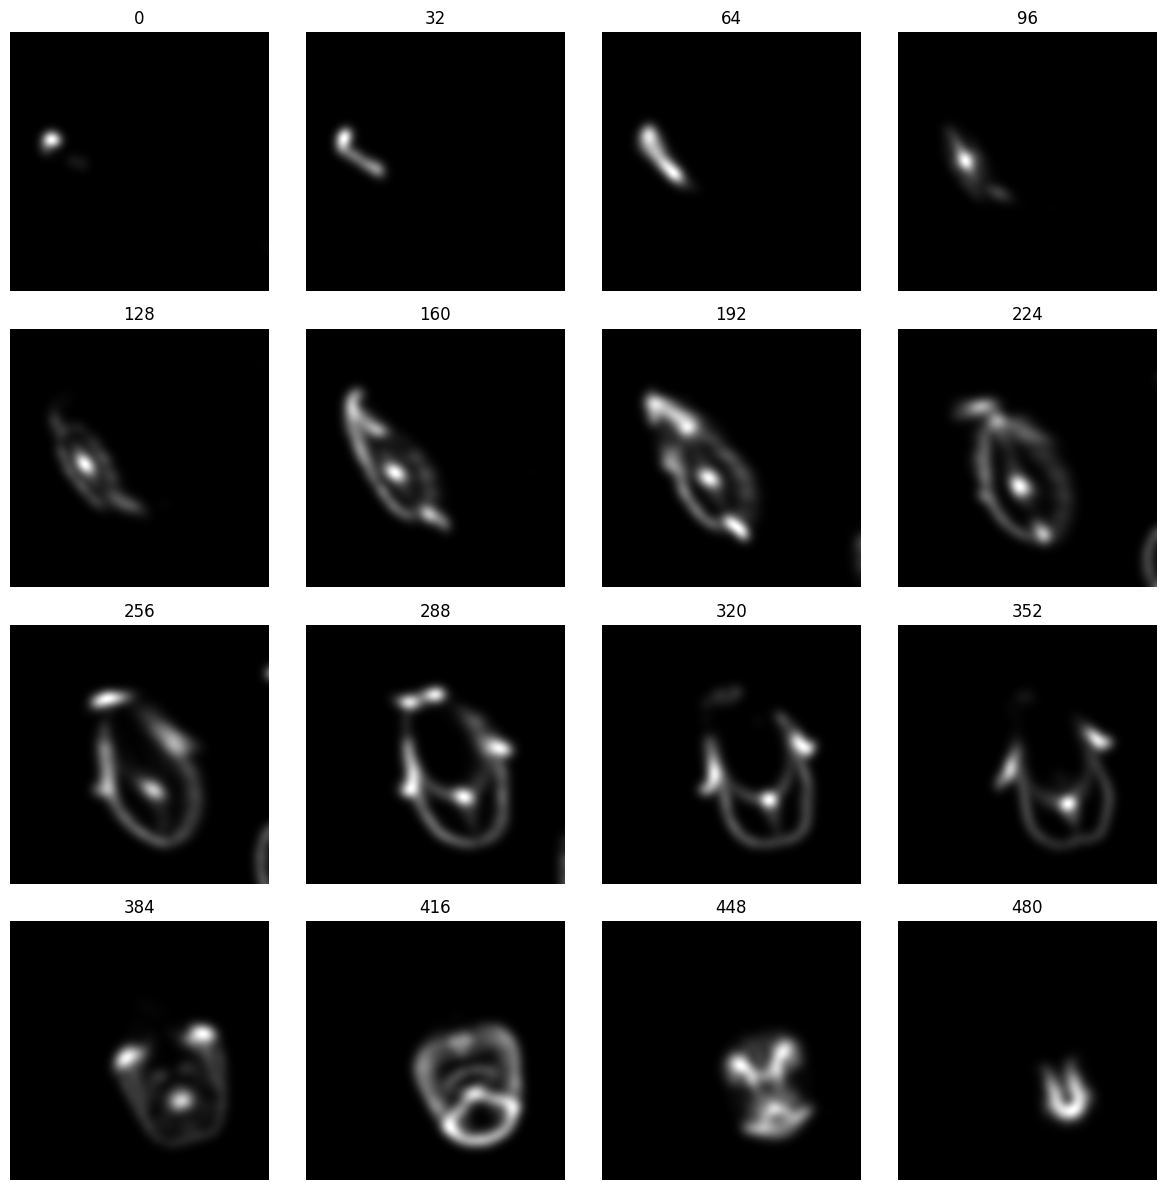

In [60]:
plot.plot_arr(filtered)

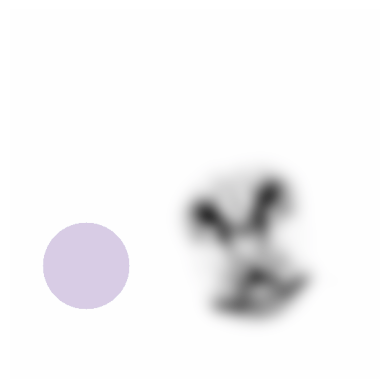

In [111]:
""" Show the kernel on top of the skull image"""
from skimage.morphology import disk

fig, axis = plt.subplots()


# Create a circle
disc = disk(ball_size)

# Pad it so it fits on top of the image
h, w = filtered[448].shape
d_h, d_w = disc.shape
offset = -100, 150
pad_h = (h - d_h) // 2 - offset[0], (h - d_h + 1) // 2 + offset[0]
pad_w = (w - d_w) // 2 - offset[1], (w - d_w + 1) // 2 + offset[1]

disc = np.pad(disc, pad_width=((pad_h, pad_w)))

axis.imshow(filtered[448], cmap="binary")
axis.imshow(disc, alpha=0.2, cmap="Purples")

axis.set_axis_off()

In [126]:
""" Convolve in 3d with a spherical kernel """

from skimage.metrics import structural_similarity

# correlation = correlate_sparse(filtered, kernel=struct)
filtered.shape, struct.shape
h, w, d = struct.shape


def similarity(patch):
    """
    Similarity between a patch and the kernel

    """
    return structural_similarity(
        patch,
        struct,
        gaussian_weights=True,
        sigma=1.5,
        use_sample_covariance=False,
        data_range=filtered.max(),
    )


# Choose a step size
step_size = 5

# Find how many steps we can take in each direction, initialise an array


In [16]:
""" Find the max value of the convolution - this should be where the skull is """

' Find the max value of the convolution - this should be where the skull is '

In [ ]:
voxel_proc.join()